

## RapidOCR Python Demo



#### Install rapidocr_onnxruntime

In [ ]:
!pip install rapidocr_onnxruntime
!wget -O 2.jpg https://pic1.zhimg.com/v2-612e2d58bd9f5f4a99c448a4d626ce86_1440w.jpg?source=172ae18b
!wget https://github.com/RapidAI/RapidOCR/releases/download/v1.1.0/FZYTK.TTF

Looking in indexes: https://pypi.douban.com/simple/
     ---------------------------------------- 12.3/12.3 MB 2.7 MB/s eta 0:00:00


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


#### Run

[[[[660.0, 15.0], [686.0, 14.0], [688.0, 83.0], [662.0, 84.0]], '格招打', 0.8068139], [[[57.0, 134.0], [484.0, 136.0], [484.0, 178.0], [57.0, 176.0]], '这时我看见他的背影，', 0.99692094], [[[60.0, 217.0], [538.0, 217.0], [538.0, 256.0], [60.0, 256.0]], '我的泪很快地流下来了。', 0.9964092], [[[58.0, 294.0], [396.0, 296.0], [396.0, 339.0], [58.0, 337.0]], '我赶紧拭干了泪，', 0.98592407], [[[57.0, 372.0], [257.0, 374.0], [257.0, 420.0], [57.0, 418.0]], '怕他看见，', 0.9982783], [[[58.0, 453.0], [350.0, 455.0], [350.0, 498.0], [58.0, 496.0]], '也怕别人看见。', 0.9979418], [[[68.0, 568.0], [191.0, 568.0], [191.0, 609.0], [68.0, 609.0]], '《背影》', 0.9973544]]
[1.1213593499999206, 0.029864072799682617, 0.7594971656799316]


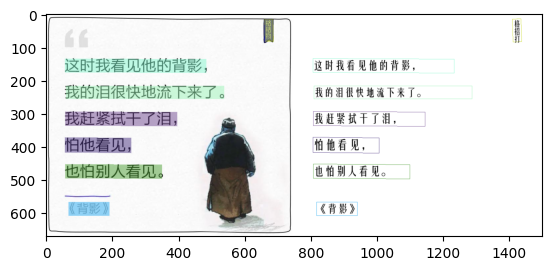

In [ ]:
import cv2
from matplotlib import pyplot as plt
from rapidocr_onnxruntime import RapidOCR, VisRes

engine = RapidOCR()
vis = VisRes()

image_path = '2.jpg'
img = cv2.imread(image_path)

result, elapse_list = engine(img)
print(result)
print(elapse_list)

boxes, txts, scores = list(zip(*result))

font_path = "FZYTK.TTF"
vis_img = vis(img, boxes, txts, scores, font_path)
plt.imshow(vis_img)